# CNN Encoder + RNN Time Series Prediction Model with Limit Orderbook Data

### Requirements
- Implement Your Own CNN Encoder +  LSTM Model for Trinary Classification Model

### Data Download at: https://drive.google.com/open?id=1_GXzTuyIopvkkOeCxHanVZKa0tKclD6F

# Data Preprocessing


#### Procedures
- Preparation
  1. Unzip Data
  2. Configurations

- Preprocessing
  1. Import Data
  2. Create Balanced Panel
  3. Create Target Variable
  4. Scale Data
  5. Train / Test Split
  6. Create Sequences
 

### Data Description
- There are two files, 1. "coin_price_dfs.csv" and 2. "orderbook_dfs.csv"

1. coin_price_dfs.csv
  - This dataset includes price (high, low, start, last, volume) for 1 minute interval
  - columns
    -  timestamp: trading time
    - currency: type of currency
    - price
      - high
      - last
      - low
      - start
    - volume: trading volume
    
2. orderbook_dfs.csv
 - This dataset includes order book information for 1 minute interval
 - columns
    - timestamp: trading time
    - ask_price: the lowest price for selling order
    - ask_strength [0~99]: each bin contains the volume of ask order in between - 0.1% x (num) ~ - 0.1% x (num+1) from  last price
    - bid_price: the highest price for buying order
    - bid_stregth [0~99]: each bin contains the volume of bid order in between - 0.1% x (num) ~ - 0.1% x (num+1) from  last price
    - currency: type of currency
    - bid_ask_spread: spread between ask and bid price

## Preparation

### 1. Data Import and Create Balanced Panel

In [0]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
DATA_PATH = "/content/gdrive/My Drive/Lecture/StudyPie/Data/CoinOne/"

In [4]:
!ls "/content/gdrive/My Drive/Lecture/StudyPie/Data/CoinOne/"

coin_price_dfs.csv  __MACOSX  orderbook_data.zip  orderbook_dfs.csv


In [0]:
# Unzip Data
# It will take more than 5 min
import zipfile
import io

zf = zipfile.ZipFile(DATA_PATH+"orderbook_data.zip", "r")
zf.extractall(DATA_PATH)

### 2. Configurations

In [0]:
currency_types = ["btc","xrp","eth","bch"]
currency_targets = ["btc"]

TIME_FREQUENCY = 1 # 1, 2, 3, 30 minutes
TIME_SEQ_LEN = 60
FUTURE_PERIOD_PREDICT = 5

# NUM_DEPENDENT_VARIABLE == 2: increase/decrease
# NUM_DEPENDENT_VARIABLE == 3: incrase/no change/decrease
NUM_DEPENDENT_VARIABLE = 3
SIGNIFICANT_CRITERIA = 0.3 # for no change criteria

BATCH_SIZE = 128
NUM_ITERATIONS = 30

TRAIN_RATIO = 0.8

## Preprocessing

### 1. Import Data

In [7]:
import pandas as pd

# read coin price data
coin_price_dfs = pd.read_csv(DATA_PATH+"coin_price_dfs.csv")
# read orderbeook data
orderbook_dfs = pd.read_csv(DATA_PATH+"orderbook_dfs.csv")    

# sort by timestamp
coin_price_dfs = coin_price_dfs.sort_values(by=['timestamp','currency'])
orderbook_dfs = orderbook_dfs.sort_values(by=['timestamp','currency'])    

# select the columns of interests
coin_price_dfs = coin_price_dfs[coin_price_dfs["currency"].isin(currency_types)]
orderbook_dfs = orderbook_dfs[orderbook_dfs["currency"].isin(currency_types)]

print(coin_price_dfs.shape)
print(orderbook_dfs.shape)

(136916, 15)
(136827, 213)


### 2. Create Balanced Panel

In [0]:
coinprice_features = ['currency','last','volume','timestamp']

# we only use bid / ask volume data inbetween current price and 3% from it (-3%,-2.9%, =2.8% ...0%, 0.1%, 0.2%... 3%)
bid_cols = ["bid_strength_"+str(i) for i in range(30)]
ask_cols = ["ask_strength_"+str(i) for i in range(30)]
orderbook_features = bid_cols + ask_cols + ["currency","timestamp","bid_ask_spread"]

key_features = coinprice_features + orderbook_features

# merge price and orderbook data based on timestamp
panel_df = pd.merge_asof(left=coin_price_dfs[coinprice_features].reset_index(drop=True), 
                         right=orderbook_dfs[orderbook_features].reset_index(drop=True),
                         on = u'timestamp', by = u'currency')
## interpolation
panel_df = panel_df.groupby('currency').apply(lambda gp: gp.fillna(method="ffill"))
panel_df.dropna(inplace=True)

In [9]:
panel_df[panel_df['currency']=='btc'].head(n=5)

,currency,last,volume,timestamp,bid_strength_0,bid_strength_1,bid_strength_2,bid_strength_3,bid_strength_4,bid_strength_5,...,ask_strength_21,ask_strength_22,ask_strength_23,ask_strength_24,ask_strength_25,ask_strength_26,ask_strength_27,ask_strength_28,ask_strength_29,bid_ask_spread
5,btc,7179000.0,0.1953,2.560792e+07,2.2262,0.5006,5.0065,8.2713,0.0408,1.3164,...,0.0,0.0,0.0,1.0009,6.4400,0.0,0.0,5.5278,0.0005,8000.0
9,btc,7171000.0,1.3128,2.560792e+07,2.2262,4.3329,5.0034,4.3283,0.0408,1.3164,...,0.0,0.0,0.0,1.0009,6.4400,0.0,0.0,5.5278,0.0059,8000.0
13,btc,7171000.0,0.5334,2.560792e+07,5.8373,0.1031,8.8948,0.4727,1.3214,0.2364,...,0.0,0.0,0.0,0.0000,7.4409,0.0,0.0,0.0000,5.5337,1000.0
17,btc,7171000.0,0.1500,2.560792e+07,6.6385,0.3035,8.8948,0.4727,1.3215,0.2364,...,0.0,0.0,0.0,0.0000,7.4409,0.0,0.0,0.0000,5.5337,1000.0
21,btc,7178000.0,0.1211,2.560792e+07,6.6385,0.1031,6.9853,0.5867,1.3214,0.0636,...,0.0,0.0,0.0,0.0000,7.4409,0.0,0.0,0.0000,5.5337,1000.0


In [10]:
# our dataset is not balanced yey
# we need to transform dataframe into (timestamp - coin1 - coin2 - coin3 ...)
new_panel_df_list = []

for currency_type in currency_types:  # begin iteration
  new_col_names = {key_feature:currency_type+"_"+key_feature 
                   for key_feature in key_features if key_feature != "timestamp"}

  single_currency_panel_df = panel_df[panel_df['currency']==currency_type]
  single_currency_panel_df.rename(columns=new_col_names, inplace=True)

  print(currency_type, " size: ", single_currency_panel_df.shape[0])    
  new_panel_df_list.append(single_currency_panel_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


btc  size:  34224
xrp  size:  34225
eth  size:  34230
bch  size:  34228


In [0]:
balanced_panel_df = new_panel_df_list[0]

for new_panel_df in new_panel_df_list[1:]:
  balanced_panel_df = pd.merge_asof(left=balanced_panel_df.reset_index(drop=True), 
                       right=new_panel_df.reset_index(drop=True),
                       on = u'timestamp')

balanced_panel_df.dropna(inplace=True)    
balanced_panel_df.reset_index(drop=True,inplace=True)

In [12]:
balanced_panel_df.head()

,btc_currency,btc_last,btc_volume,timestamp,btc_bid_strength_0,btc_bid_strength_1,btc_bid_strength_2,btc_bid_strength_3,btc_bid_strength_4,btc_bid_strength_5,...,bch_ask_strength_21,bch_ask_strength_22,bch_ask_strength_23,bch_ask_strength_24,bch_ask_strength_25,bch_ask_strength_26,bch_ask_strength_27,bch_ask_strength_28,bch_ask_strength_29,bch_bid_ask_spread
0,btc,7178000.0,0.1211,2.560792e+07,6.6385,0.1031,6.9853,0.5867,1.3214,0.0636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2500.0
1,btc,7178000.0,0.1211,2.560792e+07,1.7127,5.3297,0.0065,9.4314,0.1528,1.2044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2500.0
2,btc,7179000.0,0.0281,2.560792e+07,1.7226,5.3273,0.0065,7.2283,0.1528,0.2044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0
3,btc,7179000.0,0.0132,2.560792e+07,1.7226,5.1290,2.3059,7.2283,0.1528,0.2044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0
4,btc,7179000.0,0.0132,2.560792e+07,1.7226,5.1290,2.1065,7.3863,0.0408,0.3164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0


###   3. Create Target Variable

In [0]:
# to create target variable we create return 
for currency_target in currency_targets:
  balanced_panel_df[currency_target+'_last_target'] = balanced_panel_df[currency_target+'_last'].shift(-FUTURE_PERIOD_PREDICT )
  balanced_panel_df[currency_target+'_last_target_return'] = (balanced_panel_df[currency_target+'_last_target'] 
                                                              - balanced_panel_df[currency_target+'_last'])/balanced_panel_df[currency_target+'_last']

In [0]:
def classify_trinary(values):
  gp_std = np.std(values)

  target = []
  for value in values:
    if SIGNIFICANT_CRITERIA*gp_std < value:
      target.append(2)
    elif -SIGNIFICANT_CRITERIA*gp_std > value:
      target.append(0)  
    else:
      target.append(1)  

  return target

In [15]:
import numpy as np

for currency_target in currency_targets:
  if NUM_DEPENDENT_VARIABLE == 2:
    print("NUM_DEPENDENT_VARIABLE: ", 2)
    balanced_panel_df[currency_target+'_target'] = balanced_panel_df[currency_target+'_last_target_return'].apply(lambda x: 0 if x <= 0 else 1)

  elif NUM_DEPENDENT_VARIABLE == 3:    
    print("NUM_DEPENDENT_VARIABLE: ", 3)
    print("SIGNIFICANT_CRITERIA:", SIGNIFICANT_CRITERIA)
    balanced_panel_df[currency_target+'_target'] = balanced_panel_df[currency_target+"_last_target_return"].transform(classify_trinary)    

  else:
    print("NUM_DEPENDENT_VARIABLE is not properly specified")

NUM_DEPENDENT_VARIABLE:  3
SIGNIFICANT_CRITERIA: 0.3


### 4. Scale Data
  5. Create Sequences
  6. Train / Test Split

  

- Training / Predicting Model
  1. Model Build
  2. Model Train
  3. Prediction
  4. Evaluation <- this assignment implement it

In [0]:
# we scaled input data using mix max scaler
from sklearn import preprocessing 

exclude_cols = [] # if you want to ignore some columns for mix max scaling, write the column here
exceptions = ["currency", "timestamp", "target"]

for col in balanced_panel_df.columns:
  exception_occur = False

  for exception in exceptions:
    if exception in col:
      exception_occur = True
      exclude_cols.append(col)

  if exception_occur:
    continue
  
  balanced_panel_df[col] = preprocessing.minmax_scale(balanced_panel_df[col].values)

In [0]:
# we sholud exclude these variable
# since we should not predict based on the future information
target_cols = [currency_target+"_target" for currency_target in currency_targets]

for target_col in target_cols:
    exclude_cols.remove(target_col) 

balanced_panel_df = balanced_panel_df.filter(regex="^(?!({0})$).*$".format('|'.join(exclude_cols)))

In [18]:
balanced_panel_df.head()

,btc_last,btc_volume,btc_bid_strength_0,btc_bid_strength_1,btc_bid_strength_2,btc_bid_strength_3,btc_bid_strength_4,btc_bid_strength_5,btc_bid_strength_6,btc_bid_strength_7,...,bch_ask_strength_22,bch_ask_strength_23,bch_ask_strength_24,bch_ask_strength_25,bch_ask_strength_26,bch_ask_strength_27,bch_ask_strength_28,bch_ask_strength_29,bch_bid_ask_spread,btc_target
0,0.259504,0.002547,0.206476,0.002404,0.149140,0.012677,0.028505,0.001294,0.005685,0.832771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,1
1,0.259504,0.002547,0.053270,0.124267,0.000139,0.203788,0.003296,0.024512,0.022489,0.765842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,1
2,0.261157,0.000589,0.053578,0.124211,0.000139,0.156185,0.003296,0.004160,0.025798,0.765842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,1
3,0.261157,0.000276,0.053578,0.119587,0.049232,0.156185,0.003296,0.004160,0.025798,0.765842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,1
4,0.261157,0.000276,0.053578,0.119587,0.044975,0.159599,0.000880,0.006439,0.022489,0.765842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136364,1


### 5. Train / Test Split

In [0]:
# split train test dataset
panel_df_train = balanced_panel_df.iloc[:int(balanced_panel_df.shape[0]*TRAIN_RATIO)]
panel_df_test = balanced_panel_df[~balanced_panel_df.index.isin(panel_df_train.index)]

### 6. Create Sequences

In [0]:
import random
from collections import deque

def sequence_generator(panel_df, TIME_SEQ_LEN, suffle=True,seed=101):

  sequential_data = []  # this is a list that will CONTAIN the sequences
  queue = deque(maxlen = TIME_SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

  for i in panel_df.values:  # iterate over the values
    queue.append([n for n in i[:-1]])  # store all but the target
    if len(queue) == TIME_SEQ_LEN:  # make sure we have 60 sequences!
      sequential_data.append([np.array(queue), i[-1]])  # append those bad boys!

  if suffle == True:
    random.seed(seed)
    random.shuffle(sequential_data)  # shuffle for good measure.

  X = []
  y = []

  for seq, target in sequential_data:  # going over our new sequential data
    X.append(seq)  # X is the sequences
    y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

  return np.array(X), y  # return X and y...and make X a numpy array!

In [0]:
train_X, train_Y = sequence_generator(panel_df_train , TIME_SEQ_LEN, suffle=True, seed=101)
test_X, test_Y = sequence_generator(panel_df_test, TIME_SEQ_LEN, suffle=False)

In [22]:
print(panel_df_train.shape)
print(train_X.shape)
print(len(train_Y))

print(panel_df_test.shape)
print(test_X.shape)
print(len(test_Y))

(27376, 253)
(27317, 60, 252)
27317
(6844, 253)
(6785, 60, 252)
6785


# Exercise CNN Encoder + RNN Time Series Prediction Model with Limit Orderbook Data

- Training / Predicting Model
  1. Model Define
    - CNN Encoder + RNN Model
    
  2. Model Train
  3. Prediction
  4. Evaluation <- this assignment implement it

### 1. Model Build

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten, Conv1D

def cnn_encoder_lstm(input_dim, output_dim):
    
  # you can try your own model!
  # Here I used 1D Conv along the time dimension
  # But you can apply 2D Conv or 1D Conv along the moneyness dimension
  # Or even you can try time distributed conv after change the shape of inputs (do not shuffle in this case)
  
  L1 = 256  # 30
  L2 = 128  # 20
  L3 = 64  # 10
  L4 = 256  # 5
  L5 = 256

  model = Sequential()
  model.add(Conv1D(filters=L1, kernel_size=5, activation='relu', 
                   padding='same', input_shape=input_dim))
  model.add(Dropout(0.2))
    
  model.add(Conv1D(filters=L2, kernel_size=4, activation='relu', padding='same'))
  model.add(Dropout(0.2))
  
  model.add(Conv1D(filters=L3, kernel_size=3, activation='relu', padding='same'))
  model.add(Dropout(0.2))
  
  model.add(LSTM(L4, return_sequences=True))

  model.add(LSTM(L5, return_sequences=True))
  
  model.add(Flatten())  
  model.add(Dropout(0.2))
  
  model.add(Dense(output_dim, activation='softmax'))
  
  model.compile(optimizer=tf.train.AdamOptimizer(0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  
  model.summary()
  return model

In [24]:
model_dict = {}
model_dict["CNN_ENCODER_LSTM"] = cnn_encoder_lstm(train_X.shape[1:], NUM_DEPENDENT_VARIABLE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 256)           322816    
_________________________________________________________________
dropout (Dropout)            (None, 60, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 128)           131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 64)            24640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 60, 256)           328704    
__________

### 2. Model Train


In [25]:
BATCH_SIZE = 64 
NUM_ITERATIONS = 10

hist = {}

for name, model in model_dict.items():

  print("===== Model Name: {} =====".format(name))    
  if name == "CNN_ENCODER_LSTM":
    hist[name] = model.fit(train_X.reshape(-1, train_X.shape[1:][0], train_X.shape[1:][1]),
                          tf.keras.utils.to_categorical(train_Y, num_classes=None), 
                          batch_size = BATCH_SIZE,
                          validation_split=0.2,
                          epochs = NUM_ITERATIONS)

  print("===== Train Done =====".format(name))

===== Model Name: CNN_ENCODER_LSTM =====
Train on 21853 samples, validate on 5464 samples
Epoch 1/10
21853/21853 [==============================] - 149s 7ms/step - loss: 1.0974 - acc: 0.3646 - val_loss: 1.0956 - val_acc: 0.3613
Epoch 2/10
21853/21853 [==============================] - 140s 6ms/step - loss: 1.0933 - acc: 0.3628 - val_loss: 1.0875 - val_acc: 0.3724
Epoch 3/10
21853/21853 [==============================] - 140s 6ms/step - loss: 1.0796 - acc: 0.3936 - val_loss: 1.0870 - val_acc: 0.3960
Epoch 4/10
21853/21853 [==============================] - 140s 6ms/step - loss: 1.0559 - acc: 0.4311 - val_loss: 1.0622 - val_acc: 0.4314
Epoch 5/10
21853/21853 [==============================] - 139s 6ms/step - loss: 1.0154 - acc: 0.4858 - val_loss: 1.0429 - val_acc: 0.4693
Epoch 6/10
21853/21853 [==============================] - 140s 6ms/step - loss: 0.9585 - acc: 0.5364 - val_loss: 0.9895 - val_acc: 0.5154
Epoch 7/10
21853/21853 [==============================] - 140s 6ms/step - loss: 0.

### 3. Prediction

In [26]:
predictions = {}

for name, model in model_dict.items():  
  print("===== Model Name: {} =====".format(name))  
  if name == "CNN_ENCODER_LSTM":
    predictions[name] = model.predict_classes(test_X.reshape(-1, train_X.shape[1:][0], train_X.shape[1:][1]))

  else:
    predictions[name] = model.predict_classes(test_X)

===== Model Name: CNN_ENCODER_LSTM =====


### 4. Evaluation

1. Comparing Accuracy both Train and Validation set data
  - Compare loss according to the below materials
  - Visualize training history  
  - Check genelarization of your model
  - Refer
    - https://medium.com/machine-learning-world/neural-networks-for-algorithmic-trading-1-2-correct-time-series-forecasting-backtesting-9776bfd9e589
  - Visualization Hint
    - https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

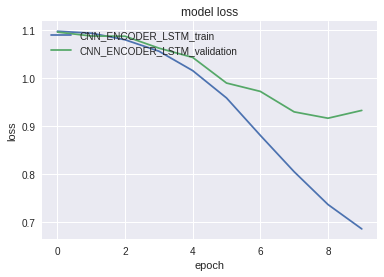

In [27]:
import matplotlib.pyplot as plt

plt.title('model loss')
legend_names = []
# summarize history for accuracy
for name, model_hist in hist.items():
  plt.plot(model_hist.history['loss'])
  plt.plot(model_hist.history['val_loss'])
  legend_names.extend([name+'_train', name+'_validation'])
  
plt.legend(legend_names, loc='upper left')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

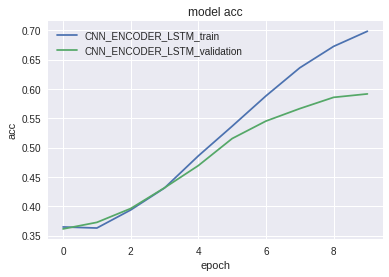

In [28]:
import matplotlib.pyplot as plt

plt.title('model acc')
legend_names = []
# summarize history for accuracy
for name, model_hist in hist.items():
  plt.plot(model_hist.history['acc'])
  plt.plot(model_hist.history['val_acc'])
  legend_names.extend([name+'_train', name+'_validation'])
  
plt.legend(legend_names, loc='upper left')

plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

2. Measure Model Accuracy for Classification Problem
  - Now we are going to evaluate our model 
  - Accuracy, Recall, F1 Score based on Confusion Matrix
  - Refer definition of each scores
    - Confusion matrix https://en.wikipedia.org/wiki/Confusion_matrix
    - Confusion matrix in Korean https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/
    
  - Hint
    - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [29]:
from sklearn.metrics import classification_report

for name, prediction_model in predictions.items():
  print("===== Model Name: {} =====".format(name))  
  print(classification_report(prediction_model, test_Y))

===== Model Name: CNN_ENCODER_LSTM =====
             precision    recall  f1-score   support

          0       0.39      0.29      0.33      2697
          1       0.25      0.42      0.32      1705
          2       0.36      0.29      0.32      2383

avg / total       0.34      0.32      0.32      6785



3. Measure Test Set Return based on the Simplest Strategy
  - Condition
    - Initial budget = 100
 - Strategy
    - If we predict up, then buy or hold (if we already bought)
    - If we predict down or no change then sell (if we already bought) or do nothing 
  - Draw your return

===== Model Name: CNN_ENCODER_LSTM =====


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


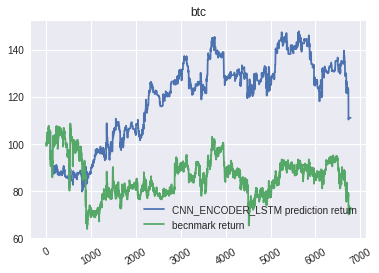

In [30]:
for name, prediction_model in predictions.items():
  print("===== Model Name: {} =====".format(name))  
  
  for currency_target in currency_targets:
      bechmark_return = 100
      bechmark_return_history = []

      prediction_return = 100
      prediction_return_history = []

      buy_price = 0
      sell_price = 0

      hold = False

      panel_df_test[currency_target+'_last_return'] = panel_df_test[currency_target+'_last'].pct_change()
      
      for prediction, (i, r) in zip(prediction_model, panel_df_test.iloc[TIME_SEQ_LEN-1:].iterrows()):

          if hold == True:
              prediction_return = prediction_return*(1+r[currency_target+'_last_return'])  

          bechmark_return = bechmark_return*(1+r[currency_target+'_last_return'])
          bechmark_return_history.append(bechmark_return)
          prediction_return_history.append(prediction_return)

          if prediction ==2:
              hold = True
          else: 
              hold = False

      plt.title(currency_target)
      plt.plot(prediction_return_history, label = name+' prediction return')    
      plt.plot(bechmark_return_history, label = 'becnmark return')
      plt.xticks(rotation=30)
      plt.legend()
      plt.show()